# Deflection by an extended mass distribution

In this application, we implement the calculation of the deflection angle field by an extended lens. A two-dimensional map of the lens surface-density is contained the ```data``` forlder and it is called ```kappa_2.fits```. To be precise, this is the surface density divided by a constant which depends on the lens and source redshifts (we will talk about this constant in the next lectures). Let's denote this quantity as $\kappa$. Accounting for this normalization, the calulation we want to implement is 
$$
\vec\alpha(\vec x)=\frac{1}{\pi}\int\kappa(\vec x')\frac{\vec x-\vec x'}{|\vec x-\vec x'|^2}d^2 x' \;.
$$
This is a convolution, which can be written in the Fourier Space as
$$
\vec{\tilde\alpha}(\vec k)=\frac{1}{\pi} \tilde\kappa (\vec k) \vec{\tilde K} (\vec k) 
$$
where  $\vec{\tilde{K}}(\vec{k})$ is the Fourier Transform of 
$$
\vec{K}(\vec x)=\frac{\vec{x}}{|\vec{x}|^2}
$$

To implement this calculation, we use the ```numpy.fft``` module.

In [1]:
import numpy as np
import numpy.fft as fftengine
import matplotlib.pyplot as plt
%matplotlib inline

We define a class called deflector, where the deflector object is initialized throught a fits file containing the surface density map of the lens.
To deal with the fits files, we need to use the ```astropy.io.fits``` module.

The class contains some methods to 
* build the kernel $K(\vec{x})$
* compute the deflection angle map by convolving the convergence with the kernel 
* perform the so-called "zero-padding"

In [2]:
import astropy.io.fits as pyfits

class deflector(object):
    
    # initialize the deflector using a surface density (covergence) map
    # the boolean variable pad indicates whether zero-padding is used or not
    def __init__(self,filekappa,pad=False):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        self.kx,self.ky=self.kernel()
        
    # implement the kernel function K
    def kernel(self):
        x=np.linspace(-0.5,0.5,self.kappa.shape[0])
        y=np.linspace(-0.5,0.5,self.kappa.shape[1])
        kx,ky=np.meshgrid(x,y)
        norm=(kx**2+ky**2+1e-12)
        kx=kx/norm
        ky=ky/norm
        return(kx,ky)
    
    # compute the deflection angle maps by convolving
    # the surface density with the kernel function
    def angles(self):
        # FFT of the surface density and of the two components of the kernel
        kappa_ft = fftengine.fftn(self.kappa,axes=(0,1))
        kernelx_ft = fftengine.fftn(self.kx,axes=(0,1),
                                     s=self.kappa.shape)
        kernely_ft = fftengine.fftn(self.ky,axes=(0,1),
                                     s=self.kappa.shape)
        # perform the convolution in Fourier space and transform the result
        # back in real space. Note that a shift needs to be applied using 
        # fftshift
        alphax = 1.0/np.pi/(self.kappa.shape[0])*\
                fftengine.fftshift(fftengine.ifftn(kappa_ft*kernelx_ft))
        alphay = 1.0/np.pi/(self.kappa.shape[0])*\
                fftengine.fftshift(fftengine.ifftn(kappa_ft*kernely_ft))
        return(alphax.real,alphay.real)
    
    # returns the surface-density (convergence) of the deflector
    def kmap(self):
        return(self.kappa)
    
    # performs zero-padding
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros) in a
        # frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
    
    # crop the maps to remove zero-padded areas and get back to the original 
    # region.
    def mapCrop(self,mappa):
        xmin=self.kappa.shape[0]/2-self.nx/2
        ymin=self.kappa.shape[1]/2-self.ny/2
        xmax=xmin+self.nx
        ymax=ymin+self.ny
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)
    
    # alternative using astropy.convolve, which can also include zero-padding
    # and many other features:
    # http://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html
    def angles_alternative(self):
        from astropy.convolution import convolve, convolve_fft
        angx = 1.0/np.pi/(self.kappa.shape[0])*convolve_fft(self.kappa, self.kx, 
                                                            fft_pad=False,allow_huge=True)
        angy = 1.0/np.pi/(self.kappa.shape[0])*convolve_fft(self.kappa, self.ky,
                                                            fft_pad=False,allow_huge=True)
        return(angx,angy)


    def potential(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fftengine.fftfreq(self.kappa.shape[0])\
                                 ,fftengine.fftfreq(self.kappa.shape[1])))
        pix=1 # pixel scale (now using pixel units)
        #Compute Laplace operator in Fourier space = -4*pi*k^2
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fftengine.fftn(kappa)
        #compute the FT of the potential
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fftengine.ifftn(kappa_ft) #units should be rad**2
        return potential.real
    
def convergence(a1,a2):
    a12,a11=np.gradient(a1)
    a22,a21=np.gradient(a2)
    kappa=0.5*(a11+a22)
    return(kappa)    

We can now build a deflector and use it to compute the deflection angles employing the method ```angles```: 

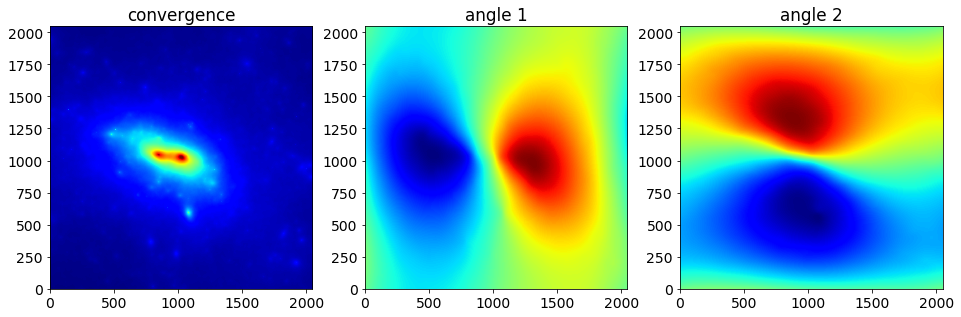

In [4]:
plt.rcParams['image.cmap'] = 'jet'
df=deflector('data/kappa_2.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

#plot the results
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower",vmax=2.5)
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('no_padding.png')

Note that at this point we have not yet used the zero-padding trick. FFT assumes periodic boundaries conditions, meaning that the lens mass distribution is replicated outside the boundaries. Given that the region around the lens considered in this example is relatively small, we expect that the deflection angles will be biased near the borders.  
The three panels in the figure above show the maps of the convergence and of the two components of the deflection angles obtained with this setting. 

Zero-padding consists of placing zeros all around the convergence map. By doing so, we double the size of the original  map, but we expect to increase the accuracy of the calculations near the borders, beacause the periodic conditions are better reproduced in this setting. We activate zero-padding by just setting the variable ```pad=True``` when initializing the deflector. The figure below shows the zero-padded convergence map and the two new maps of the deflection angle components.  

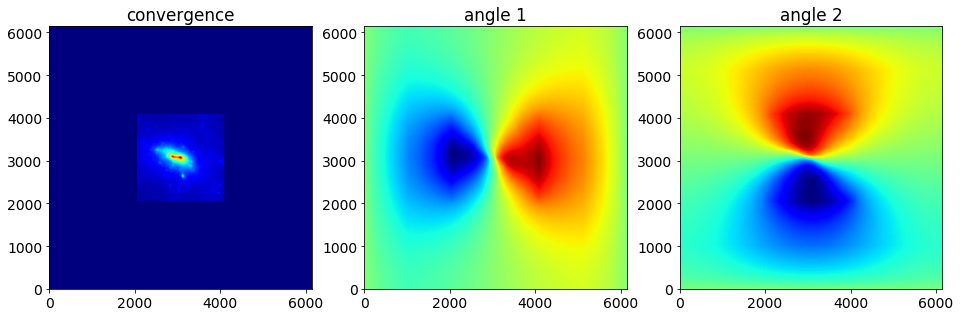

In [5]:
df=deflector('data/kappa_2.fits',True)
angx,angy=df.angles()
angx_nopadc,angy_nopadc=df.angles_alternative()
kappa=df.kmap()

fig,ax = plt.subplots(1,3,figsize=(16,8))
angx,angy=df.angles()
ax[0].imshow(kappa,origin="lower",vmax=2.5)
ax[0].set_title('convergence')
ax[1].imshow(angx,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('padding.png')

We are not interested in this large area, thus we can get rid of the values outside the lens convergence map by cropping the deflection angle maps. The results are shown below and compared to the previous ones. In fact, significant differences are visible along the borders. 

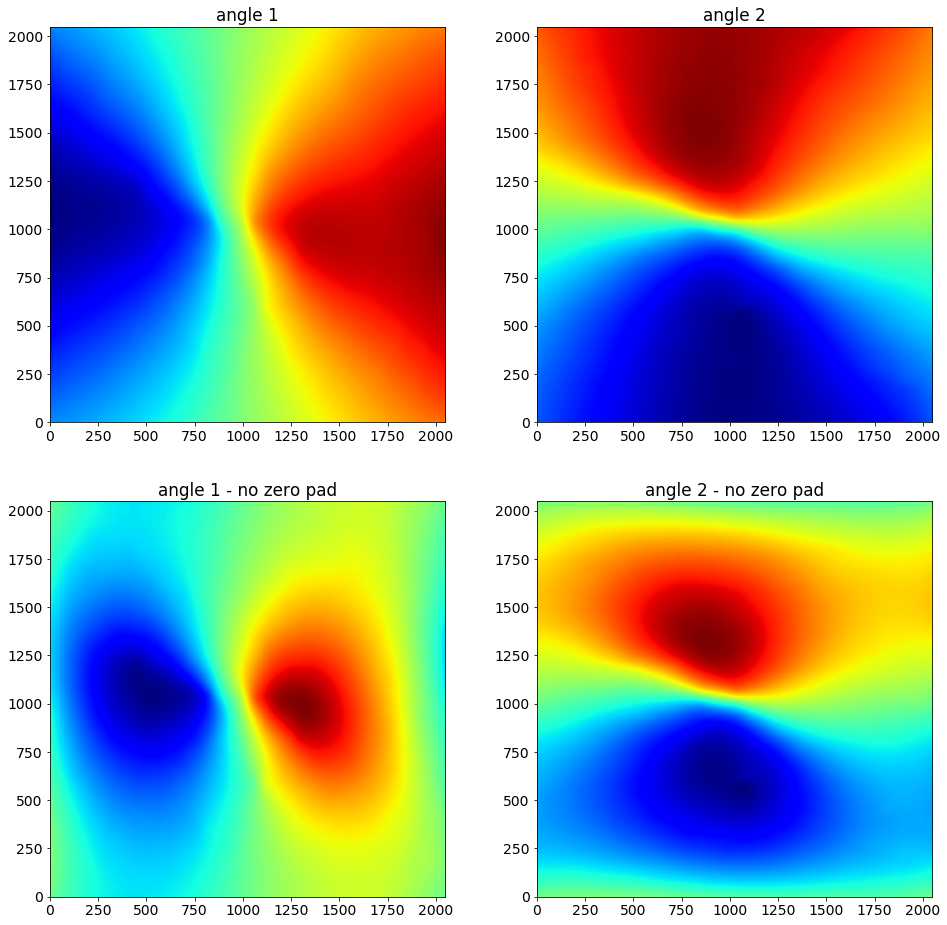

In [152]:
angx=df.mapCrop(angx)
angy=df.mapCrop(angy)

fig,ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(angx,origin="lower")
ax[0,0].set_title('angle 1')
ax[0,1].imshow(angy,origin="lower")
ax[0,1].set_title('angle 2')
ax[1,0].imshow(angx_nopad,origin="lower")
ax[1,0].set_title('angle 1 - no zero pad')
ax[1,1].imshow(angy_nopad,origin="lower")
ax[1,1].set_title('angle 2 - no zero pad')
fig.savefig('padding_cropped.png')

Text(0.5,1,u'true convergence')

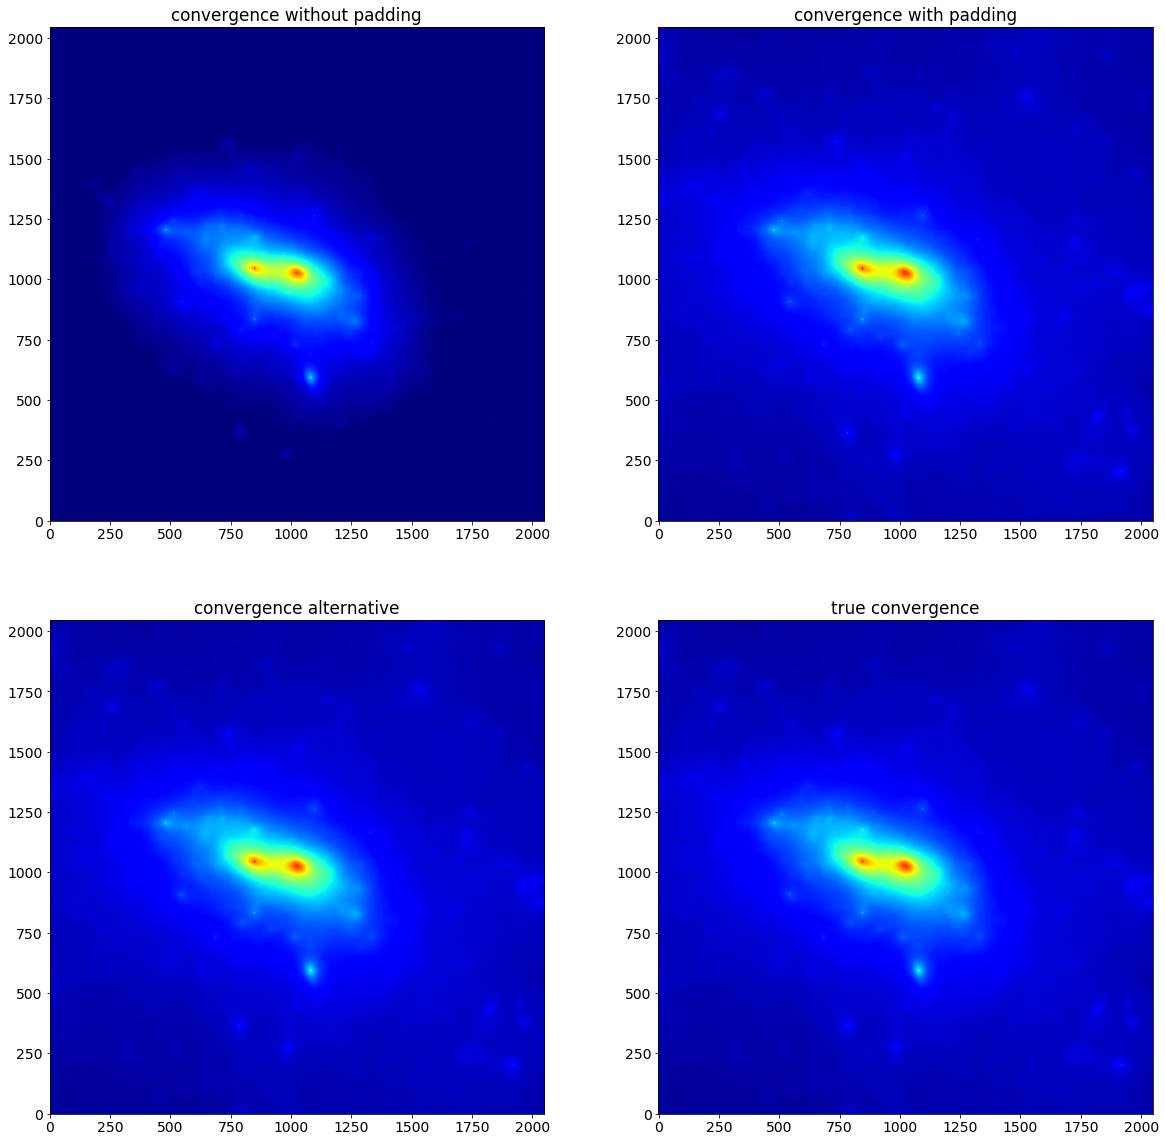

In [154]:
kappa_pad=convergence(angx,angy)
kappa_nopad=convergence(angx_nopad,angy_nopad)
kappa_alt=convergence(angx_nopadc,angy_nopadc)
fig,ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(kappa_nopad,origin="lower",vmin=0.0,vmax=3.0)
ax[0,0].set_title('convergence without padding')
ax[0,1].imshow(kappa_pad,origin="lower",vmin=0.0,vmax=3.0)
ax[0,1].set_title('convergence with padding')
ax[1,0].imshow(df.mapCrop(kappa_alt),origin="lower",vmin=0.0,vmax=3.0)
ax[1,0].set_title('convergence alternative')
ax[1,1].imshow(df.mapCrop(kappa),origin="lower",vmin=0.0,vmax=3.0)
ax[1,1].set_title('true convergence')

# Ray-tracing

In this exercise, we will implement a simple ray-tracing algorithm. In ray-tracing, we make use of the lens equation to propagate a bundle of light-rays from the observer position, through a regular grid covering the lens plane, to the source plane. For each ray passing through the position $\vec x^{ij}$, we will evaluate the deflection angle $\vec\alpha(\vec x^{ij})$ and compute the arrival position on the source plane as
$$
\vec y^{ij}=\vec x^{ij}-\vec{\alpha}(\vec x^{ij}) \;.
$$
In the formula above, $(i,j)$ identify the ray passing through the grid point with indexes $i$ and $j$ along the $x_1$ and $x_2$ axes, respectively. 

The deflector used in this example is the same of the previous exercise. In particular, we will use the deflection angle maps shown in the upper panels of the figure above to propagate the light rays towards the sources. 

## Creating a mesh on the lens plane

We start by creating a mesh, where each grid-point has two coordinates. Suppose coordinates along the $x_1$ and $x_2$ axes are represented by the $n_{pix}$-dimensional vectors  $|x_1^{i}|$ and $|x_2^j|$, with $i,j\in [1,n_{pix}]$ (so that $n_{pix}$ is the number of grid points along one axis on the mesh). The mesh can be created using the ```numpy.meshgrid``` method, as e.g.



In [124]:
npix=angx.shape[0]
x1=np.linspace(0.0,1.0,npix)*(npix-1) # define x1 coordinates
x2=np.linspace(0.0,1.0,npix)*(npix-1) # define x2 coordinates
x1_,x2_=np.meshgrid(x1,x2) # lens plane mesh
x2_[:,0]

array([  0.00000000e+00,   1.00000000e+00,   2.00000000e+00, ...,
         2.04500000e+03,   2.04600000e+03,   2.04700000e+03])

This will generate two numpy arrays, ```x1_``` and ```x2_```, with size $n_{pix} \times n_{pix}$. In the first, the values on the $i-$th column will be equal to $x_1^{i}$; in the second, the values on the $j-$th row will be equal to $x_2^{j}$.

## Compute the arrival positions of each ray on the source plane

We may now implement the lens equation for the two components along $x_1$ and $x_2$:

(0, 2047)

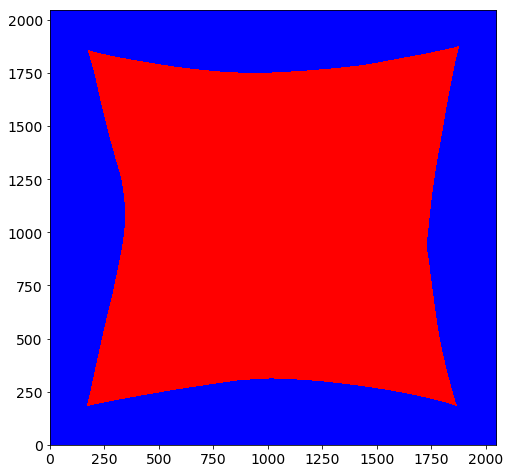

In [125]:
y1=x1_-angx
y2=x2_-angy

#plot the results
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(np.reshape(x1_,x1_.size),np.reshape(x2_,x2_.size),',',color='blue')
ax.plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),',',color='red')
ax.set_xlim([0,npix-1])
ax.set_ylim([0,npix-1])

### Alternative approaches: broadcasting, loops

In fact, we could arrive to the same result by using a feature in numpy called *broadcasting*. The term broadcasting describes how numpy treats arrays with different shapes during arithmetic operations. Subject to certain constraints, the smaller array is “broadcasted” across the larger array so that they have compatible shapes.

Using this feature, we can write the first component of the lens equation as 
$$\left[ \begin{array}{ccc}
y_1^{1,1} & \cdots & y_1^{1,n_{pix}}  \\
\vdots & \ddots & \vdots \\
y_1^{n_{pix},1} & \cdots & y_1^{n_{pix},n_{pix}}   
\end{array} \right]
=B(n_{pix},n_{pix})
\left[ \begin{array}{ccc}
x_1^1 \\
\vdots\\
x_1^{n_{pix}} 
\end{array} \right]
-
\left[ \begin{array}{ccc}
\alpha_1^{1,1} & \cdots & \alpha_1^{1,n_{pix}}  \\
\vdots & \ddots & \vdots \\
\alpha_1^{n_{pix},1} & \cdots & \alpha_1^{n_{pix},n_{pix}}
\end{array} \right]
$$

The vector ```x_1``` is then broadcast to match the size of ```alpha_1``` (the broadcasting function is here indicated as $B(n_{pix},n_{pix})$). The result will be to add  $|x_1^i|$ to each column of the matrix $-|\alpha_1^{ij}|$.

Computing the coordinates $|y_2^{ij}|$ involves few more steps. Again, using the lens equation, we obtain:
$$\left[ \begin{array}{ccc}
y_1^{1,1} & \cdots & y_1^{n_{pix},1}  \\
\vdots & \ddots & \vdots \\
y_1^{1,n_{pix}} & \cdots & y_1^{n_{pix},n_{pix}}   
\end{array} \right]
=B(n_{pix},n_{pix})
\left[ \begin{array}{ccc}
x_2^1 \\
\vdots\\
x_2^{n_{pix}} 
\end{array} \right]
-
\left[ \begin{array}{ccc}
\alpha_1^{1,1} & \cdots & \alpha_1^{n_{pix},1}  \\
\vdots & \ddots & \vdots \\
\alpha_1^{1,n_{pix}} & \cdots & \alpha_1^{n_{pix},n_{pix}}
\end{array} \right]
$$

This equation implements the column-wise addition of $|x_2^i|$ to  $-|\alpha_2^{ji}|=|\alpha_2^{ij}|^T$, where $T$ indicates the transposed matrix. The result is $|y_2^{ji}|=|y_2^{ij}|^T$. 

The python implementation is quite easy:

(0, 2047)

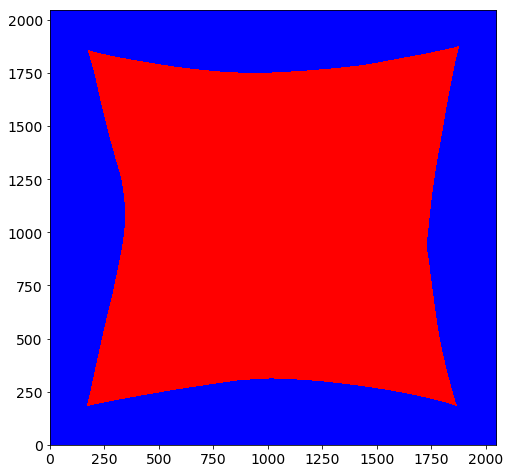

In [126]:
# ray-tracing:
y1=(x1-angx) # y1 coordinates on the source plane
y2=np.transpose(x2-np.transpose(angy)) # y2 coordinates on the source plane


#plot the results
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(np.reshape(x1_,x1_.size),np.reshape(x2_,x2_.size),',',color='blue')
ax.plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),',',color='red')
ax.set_xlim([0,npix-1])
ax.set_ylim([0,npix-1])


We can check which implementation is more efficient in terms of computational time by using the magic function ```%timeit```:

In [55]:
%timeit -n 100 y1=x1_-angx
%timeit -n 100 y1=(x1-angx)
%timeit -n 100 y2=x2_-angy
%timeit -n 100 y2=np.transpose(x2-np.transpose(angy))

100 loops, best of 3: 14.7 ms per loop
100 loops, best of 3: 13.5 ms per loop
100 loops, best of 3: 14.9 ms per loop
100 loops, best of 3: 14.1 ms per loop


We can do something similar to check memory usage:

In [56]:
%load_ext memory_profiler
%memit -r 10 y1=x1_-angx
%memit -r 10 y1=(x1-angx)
%memit -r 10 y2=x2_-angy
%memit -r 10 y2=np.transpose(x2-np.transpose(angy))

peak memory: 3034.00 MiB, increment: 0.22 MiB
peak memory: 3034.00 MiB, increment: 0.00 MiB
peak memory: 3034.00 MiB, increment: 0.00 MiB
peak memory: 3034.00 MiB, increment: 0.00 MiB


As we can see, the performace in the two implementations is very similar. What you should definitely avoid to do is using loops to perform the matrix operations above:

In [57]:
def ray_trace_x1(x1_,angx):
    y1=np.zeros(x1_.shape)
    for i in range(npix):
        for j in range(npix):
            y1[i,j]=x1_[i,j]-angx[i,j]
    return(y1)

%timeit -n 100 y1=ray_trace_x1(x1_,angx)

The slowest run took 16.13 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 1.59 s per loop


**Loops are very inefficient and should be avoided whenever it is possible. The above codes performs the same matrix subtraction discussed in the previous examples, but it is slower by more than two orders of magnitude.**

## Downsampling the grid

Let's try to downsample the grid by a factor of 64 on both sides. In this case, we have to interpolate the maps of the deflection angles at a reduced number of positions compared to the original map:

/Users/massimo/anaconda/envs/python2x/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


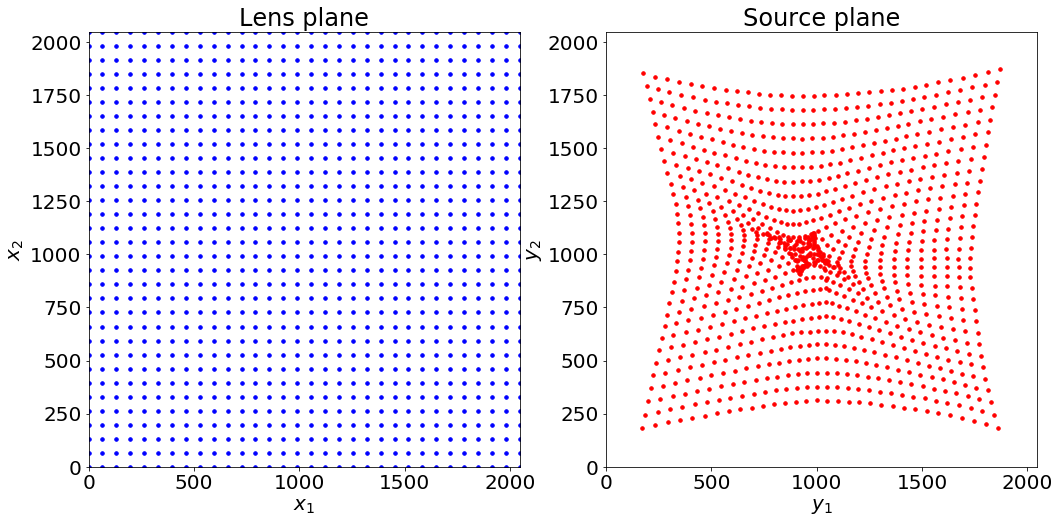

In [127]:
ndown=64
x1=np.linspace(0.0,1.0,npix/ndown)*(npix-1) # dowsampled x1,x2 coordinates
x2=np.linspace(0.0,1.0,npix/ndown)*(npix-1) # 
x1_,x2_=np.meshgrid(x1,x2) # downsampled grid
# now we need to interpolate the defl. angle maps at (x1_,x2_)
# we can use the method map_coordinates from scipy.ndimage
from scipy.ndimage import map_coordinates

# first, we need to reshape x1_ and x2_:
x=np.reshape(x1_,x1_.size)
y=np.reshape(x2_,x2_.size)
# then we interpolate:
angx_=map_coordinates(angx,[[y],[x]],order=1)
angy_=map_coordinates(angy,[[y],[x]],order=1)
# now we reshape the angles back to a mesh
angx_=angx_.reshape((npix/ndown,npix/ndown))
angy_=angy_.reshape((npix/ndown,npix/ndown))
# finally we ray-trace:
y1=x1_-angx_
y2=x2_-angy_
# or
#y1=(x1-angx_)
#y2=np.transpose(x2-np.transpose(angy_))

#plot the results
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)

fig,ax=plt.subplots(1,2,figsize=(17,8))
ax[0].plot(np.reshape(x1_,x2_.size),np.reshape(x2_,x2_.size),'o',color='blue',markersize=3.5)
ax[1].plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),'o',color='red',markersize=3.5)
ax[0].set_title('Lens plane')
ax[1].set_title('Source plane')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[1].set_xlabel('$y_1$')
ax[1].set_ylabel('$y_2$')
for i in [0,1]:
    ax[i].set_xlim([0,npix-1])
    ax[i].set_ylim([0,npix-1])

fig.savefig('raytracing.png')

# Lensing potential

An alternative approach to derive the properties of the lens is by means of the lensing potential and its derivatives.

Deriving the lensing potential from the lens convergence map requires to solve the Poisson equation in two dimensions:
$$
\kappa(\vec x) = \frac{1}{2}\triangle \Psi
$$
This can be done numerically by means of Fast-Fourier-Transform. 

The Fourier transform of the Laplace operator is
$$
\tilde{\triangle}(\vec k)=-4\pi^2 k^2
$$
where $k^2=k_1^2+k_2^2$.
Therefore, in Fourier space, the Poisson equation reads
$$
-4\pi^2k^2\tilde\Psi(\vec k)=2\tilde\kappa(\vec k) \;.
$$
The Fourier transform of the lensing potential is then
$$
\tilde\Psi(\vec k)=-\frac{\tilde\kappa(\vec k)}{2\pi^2k^2} \;.
$$


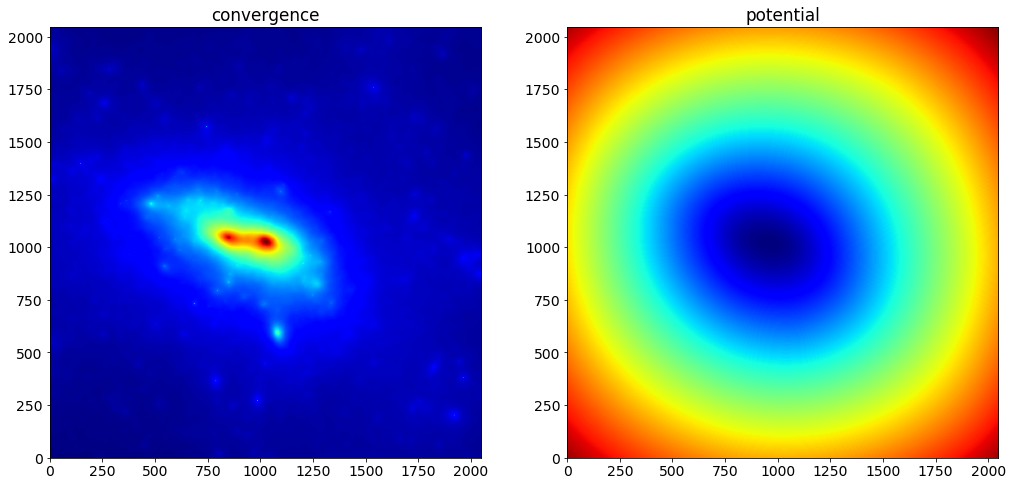

In [6]:
pot=df.potential()
kappa=df.mapCrop(kappa)
pot=df.mapCrop(pot)

fig,ax = plt.subplots(1,2,figsize=(17,8))
ax[0].imshow(kappa,origin="lower",vmax=2.5)
ax[0].set_title('convergence')
ax[1].imshow(pot,origin="lower")
ax[1].set_title('potential')
fig.savefig('potential.png')